In [ ]:
import numpy as np
from scipy.io import loadmat
import h5py
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [ ]:
hf = h5py.File('/Users/koesterlab/Documents/Maria/AhrensData/subject_1/TimeSeries.h5', 'r')
#print(hf['absIx'])
neural_dat=np.array(hf['CellResp'])
del hf

regressors=loadmat('/Users/koesterlab/Documents/Maria/AhrensData/subject_1/data_full.mat')
cell_pos=regressors['data']['CellXYZ'][0][0]
missing_values=regressors['data']['IX_inval_anat'][0][0]
cell_pos=np.delete(cell_pos,missing_values,axis=0)

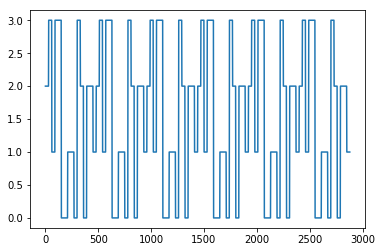

In [3]:
stim=regressors['data']['stim_full'][0][0].T
plt.plot(stim)

In [17]:
print(stim.shape)

(2880, 1)


In [4]:
change_points=[]
for j in range(0,stim.shape[0]-1):
    if stim[j]!=stim[j+1]:
        change_points.append(j)
    

In [19]:
print(change_points)

[29, 59, 89, 149, 209, 269, 299, 329, 359, 389, 449, 479, 509, 539, 569, 629, 689, 749, 779, 809, 839, 869, 929, 959, 989, 1019, 1049, 1109, 1169, 1229, 1259, 1289, 1319, 1349, 1409, 1439, 1469, 1499, 1529, 1589, 1649, 1709, 1739, 1769, 1799, 1829, 1889, 1919, 1949, 1979, 2009, 2069, 2129, 2189, 2219, 2249, 2279, 2309, 2369, 2399, 2429, 2459, 2489, 2549, 2609, 2669, 2699, 2729, 2759, 2789, 2849]


(array([46.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 24.]),
 array([30., 33., 36., 39., 42., 45., 48., 51., 54., 57., 60.]),
 <a list of 10 Patch objects>)

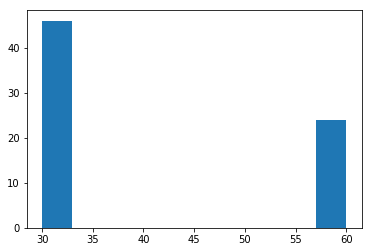

In [5]:
times=[]
for j in range(0,len(change_points)-1):
    times.append(change_points[j+1]-change_points[j])
plt.hist(times)

In [24]:
print(times)

[30, 30, 60, 60, 60, 30, 30, 30, 30, 60, 30, 30, 30, 30, 60, 60, 60, 30, 30, 30, 30, 60, 30, 30, 30, 30, 60, 60, 60, 30, 30, 30, 30, 60, 30, 30, 30, 30, 60, 60, 60, 30, 30, 30, 30, 60, 30, 30, 30, 30, 60, 60, 60, 30, 30, 30, 30, 60, 30, 30, 30, 30, 60, 60, 60, 30, 30, 30, 30, 60]


In [3]:
ind=704

In [4]:
def compute_corr_arr_for_one_cell(ind):
    start=time.time()
    corr_arr=[]   
    for t in range(0,2800,100):
        print(t)
        corr_lst=[]
        for j in range(0,83205):
            corr_lst.append(np.corrcoef(neural_dat[t:(t+100),ind],neural_dat[t:(t+100),j])[0,1])
        corr_arr.append(corr_lst)
    end=time.time()
    print('Time: ', end-start)
    corr_arr=np.array(corr_arr)
    np.save('/Users/koesterlab/Documents/Maria/AhrensData/subject_1/corr_arrays/'+str(ind)+'.npy',corr_arr)
    
#compute_corr_arr_for_one_cell(ind)

In [5]:
corr_arr=np.load('/Users/koesterlab/Documents/Maria/AhrensData/subject_1/corr_arrays/704.npy')

In [6]:
#!pip install matplotlib

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


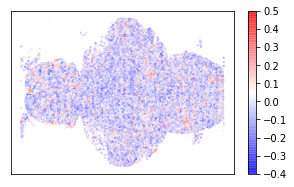

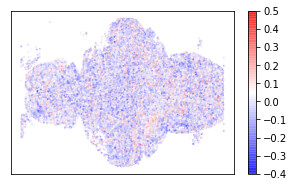

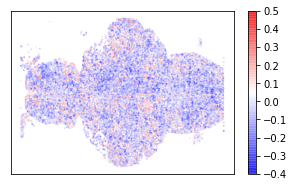

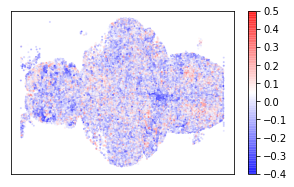

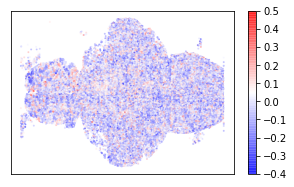

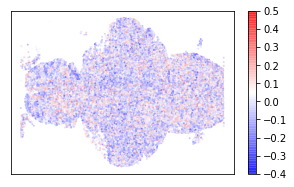

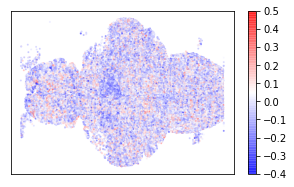

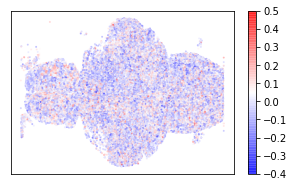

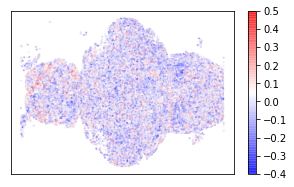

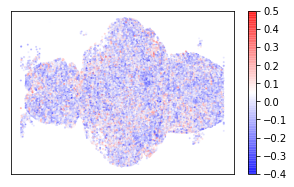

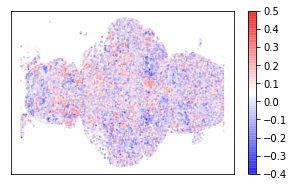

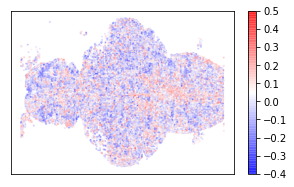

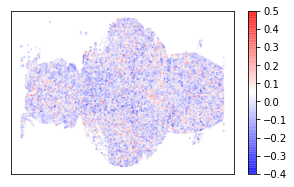

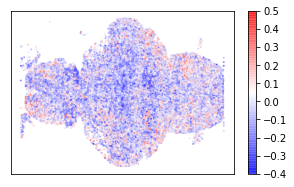

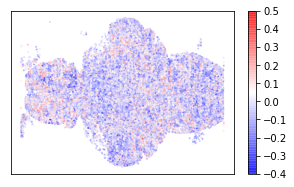

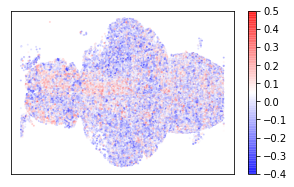

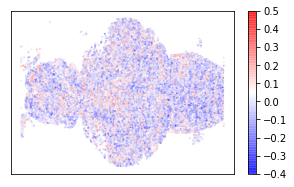

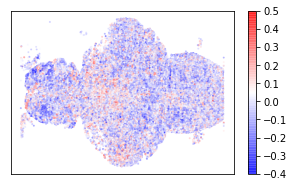

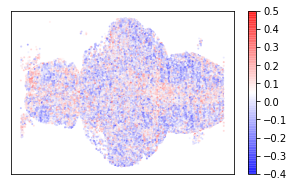

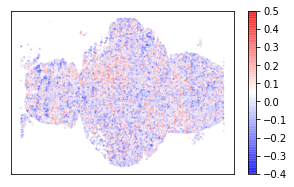

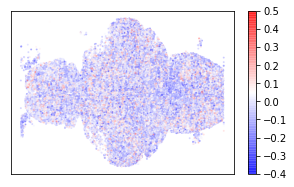

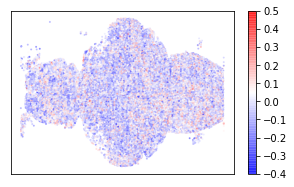

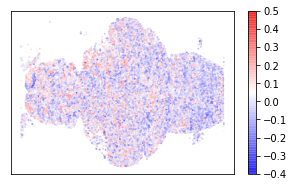

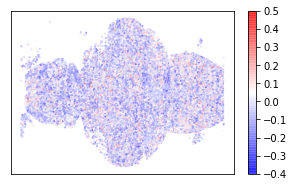

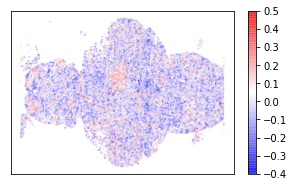

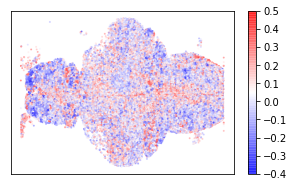

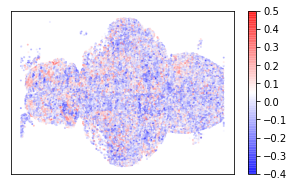

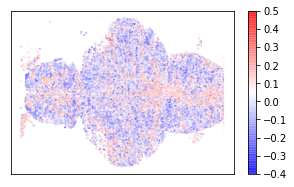

In [12]:
def make_image_files(ind,corr_arr):
    for j in range(0,28):
        fig = plt.figure(figsize=(5,3))
        plt.scatter(cell_pos[:,0], cell_pos[:,1], s = 1, c = corr_arr[j], cmap='bwr', alpha = .5, vmax=0.5, vmin=-0.4)
        plt.colorbar()
        #plt.show()
        plt.xticks([])
        plt.yticks([])
        plt.savefig('/Users/koesterlab/Documents/Maria/AhrensData/subject_1/corr_plots/'+str(ind)+'/plot_'+str(j)+'.png')
make_image_files(ind,corr_arr)

In [13]:
import imageio
import imageio
images = []
filenames=['/Users/koesterlab/Documents/Maria/AhrensData/subject_1/corr_plots/'+str(ind)+'/plot_'+str(j)+'.png' for j in range(0,28)]
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('/Users/koesterlab/Documents/Maria/AhrensData/first_gif.gif', images,fps=3)

# Logistic Regression plots

In [7]:
np.random.seed(7)
def create_train_and_test(times):
    train_inds=[]
    test_inds=[]
    running=0
    for t in times:
        #print(t)
        if t==30:
            train=np.random.choice(range(t),21,replace=False)
            test=[j for j in range(t) if j not in train]
            train.sort()
            test.sort()
        elif t==60:
            train=np.random.choice(range(t),42,replace=False)
            test=[j for j in range(t) if j not in train]
            train.sort()
            test.sort()
        for s in train:
            train_inds.append(s+running)
        for s in test:
            test_inds.append(s+running)
        running+=t
    return train_inds, test_inds

train_inds, test_inds=create_train_and_test(times)
#print(train_inds)
print(len(train_inds))
print(len(test_inds))

1974
846


In [8]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import numpy as np
sc=preprocessing.StandardScaler()
neural_train=neural_dat[train_inds,:]
neural_test=neural_dat[test_inds,:]
print(neural_train.shape)
stim_train=stim[train_inds]
stim_test=stim[test_inds]
neural_train_scaled = sc.fit_transform(neural_train)
neural_test_scaled = sc.transform(neural_test)

clf = LogisticRegression(random_state=0,C=1e8,max_iter=50).fit(neural_train_scaled, stim_train.flatten(),)
clf.score(neural_test_scaled, stim_test.flatten())

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


(1974, 83205)


0.9704491725768322

In [9]:
neural_total=sc.transform(neural_dat)

In [10]:
coeffs=clf.coef_
print(coeffs.shape)

(4, 83205)


In [12]:
def make_logit_arr(times,neural_dat, coeffs,stim):
    running=0
    logit_arr=[]
    for t in times:
        stim_label=stim[running+1]
        act=neural_dat[running:running+t]
        #print(act.shape)
        #print(coeffs.shape)
        logit=np.mean(act*coeffs[stim_label],axis=0)
        running+=t
        logit_arr.append(logit.flatten())
    logit_arr=np.array(logit_arr)
    print(logit_arr.shape)
    np.save('logit_arr.npy',logit_arr)
    return logit_arr
logit_arr=make_logit_arr(times,neural_total,coeffs,stim)
print(logit_arr)

(70, 83205)
[[ 1.38993496e-04 -1.02793593e-03  2.29830949e-03 ...  5.59027007e-05
   9.03658496e-04  5.44761268e-04]
 [-3.40926270e-04  3.05740824e-04  4.01968475e-04 ... -1.66907769e-05
   3.66214705e-04 -1.33810973e-04]
 [ 5.46269608e-05 -1.97062668e-04 -2.28053219e-05 ... -7.34244943e-05
  -8.17493390e-04  3.92335286e-06]
 ...
 [ 6.24231783e-04 -2.25791498e-04  4.50132644e-04 ... -2.68460490e-04
   1.09087766e-04 -1.82011269e-04]
 [-4.57369498e-05 -9.11189121e-04  8.74612382e-04 ... -3.76597098e-04
   9.47167043e-04  8.86927672e-05]
 [ 1.63855333e-04 -3.35154462e-04  1.17143913e-04 ...  4.06352766e-04
   5.08047626e-05 -7.56138432e-04]]


In [11]:
logit_arr=np.load('logit_arr.npy')

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


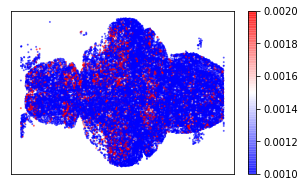

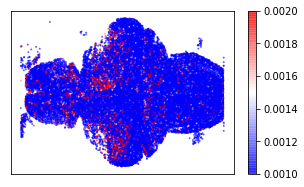

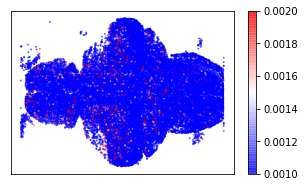

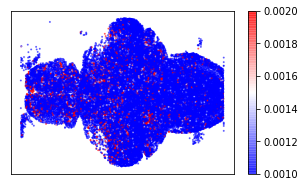

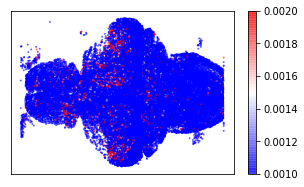

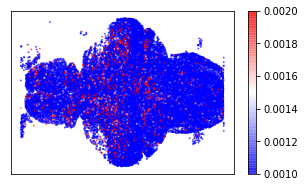

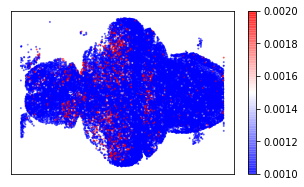

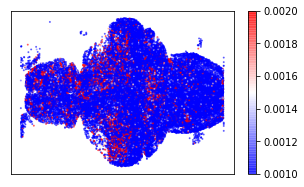

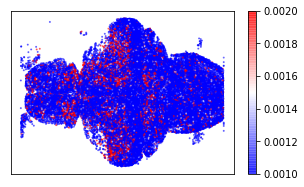

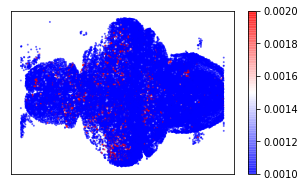

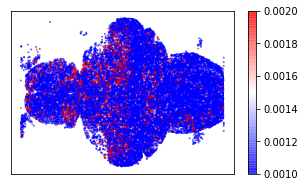

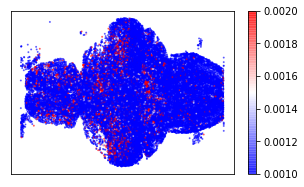

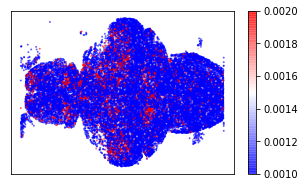

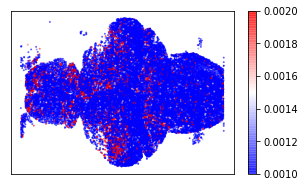

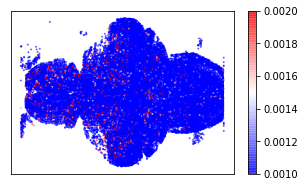

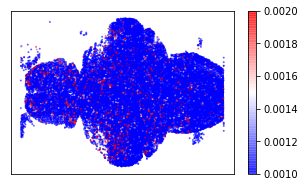

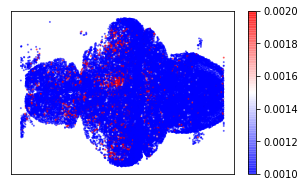

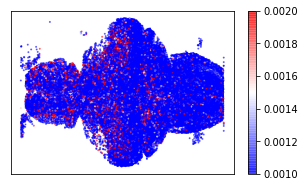

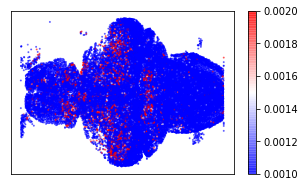

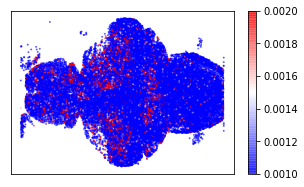

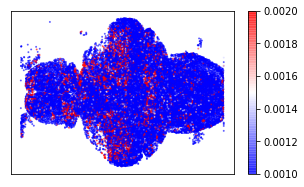

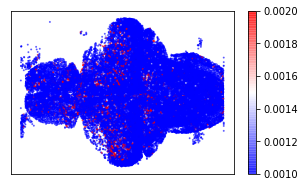

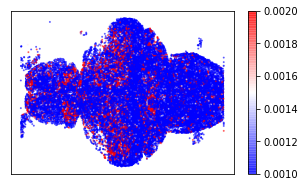

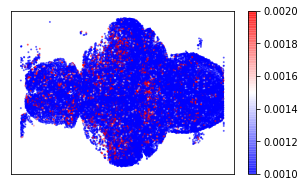

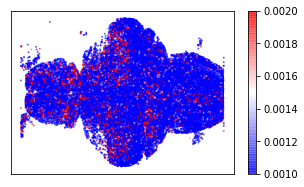

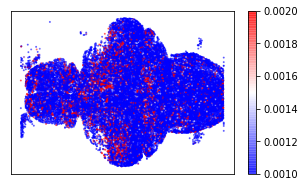

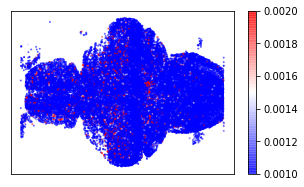

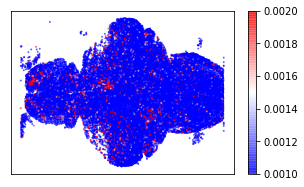

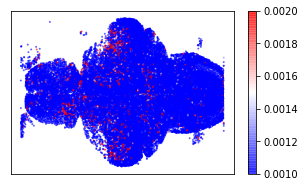

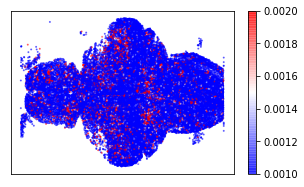

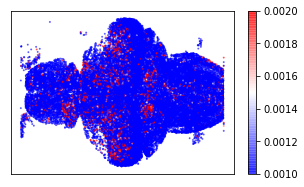

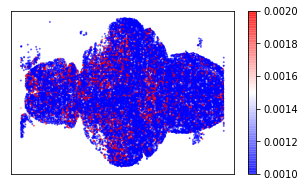

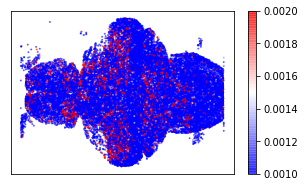

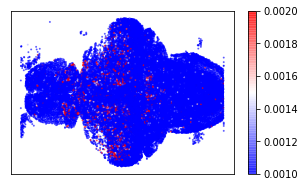

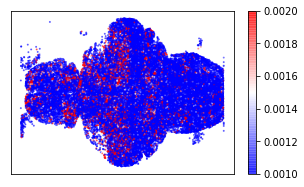

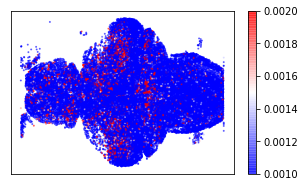

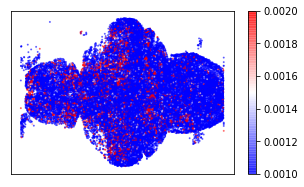

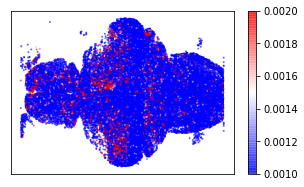

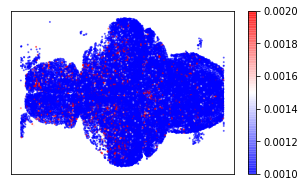

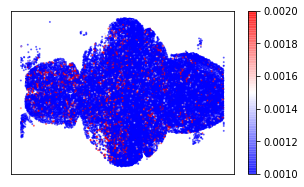

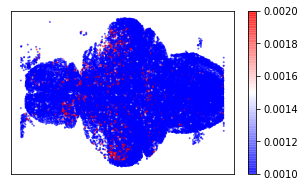

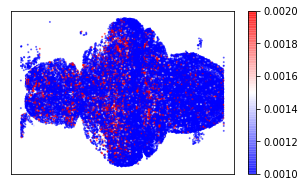

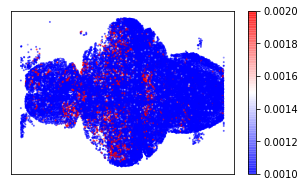

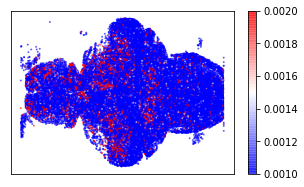

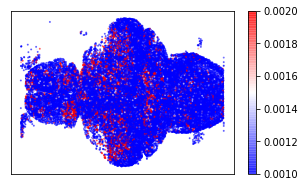

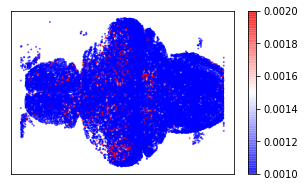

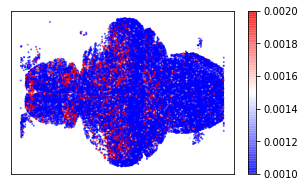

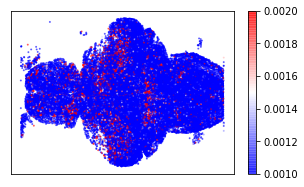

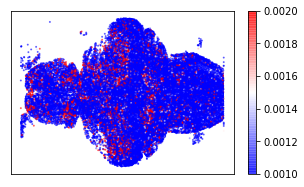

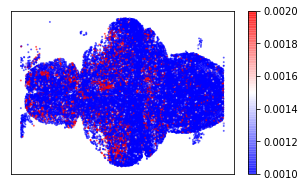

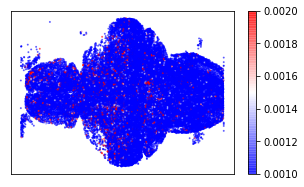

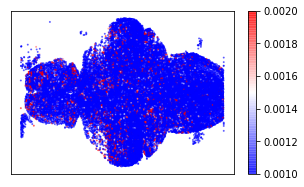

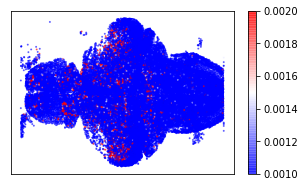

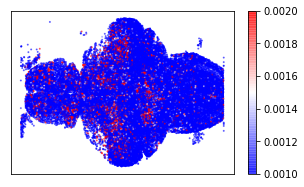

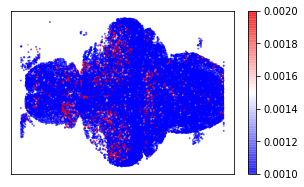

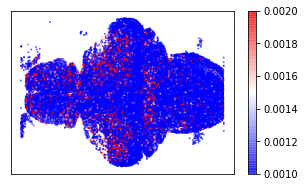

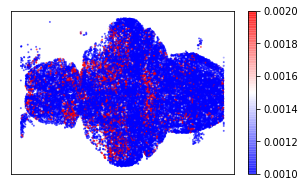

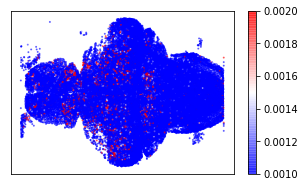

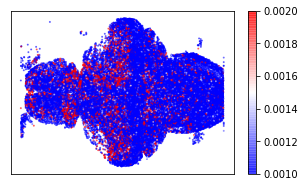

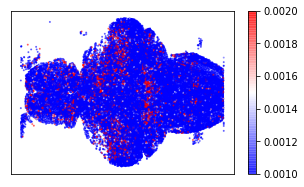

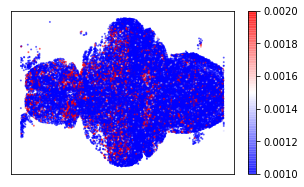

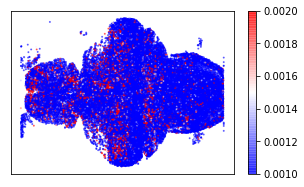

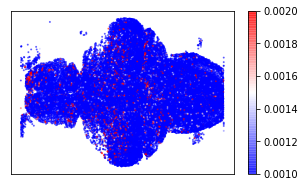

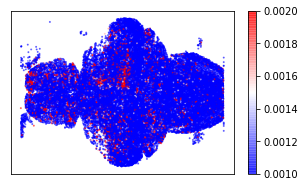

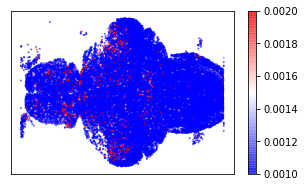

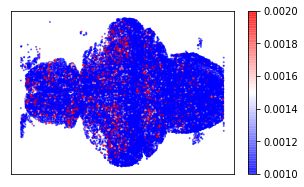

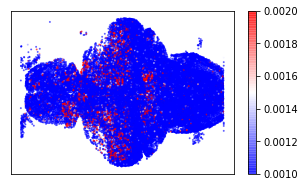

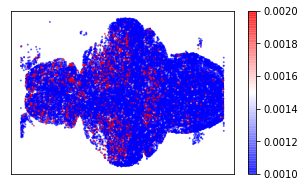

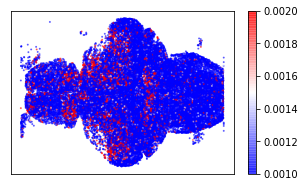

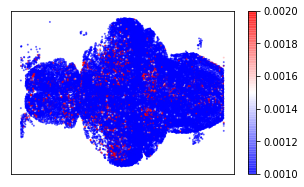

In [21]:
def make_image_logit(logit_arr,cell_pos):
    for j in range(0,70):
        fig = plt.figure(figsize=(5,3))
        plt.scatter(cell_pos[:,0], cell_pos[:,1], s = 1, c = logit_arr[j], cmap='bwr', alpha = .5,vmax=0.002,vmin=-0.001)
        plt.colorbar()
        #plt.show()
        plt.xticks([])
        plt.yticks([])
        plt.savefig('/Users/koesterlab/Documents/Maria/AhrensData/subject_1/logit_plots/plot_'+str(j)+'.png')
make_image_logit(logit_arr,cell_pos)

(-0.1, 0.002)

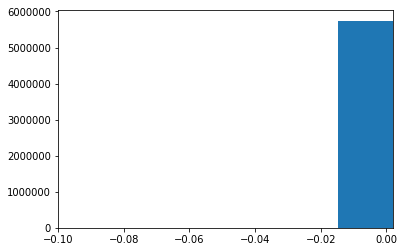

In [16]:
plt.hist(logit_arr.flatten())
plt.xlim(-0.1,0.002)

In [22]:
import imageio
import imageio
images = []
filenames=['/Users/koesterlab/Documents/Maria/AhrensData/subject_1/logit_plots/plot_'+str(j)+'.png' for j in range(0,70)]
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('/Users/koesterlab/Documents/Maria/AhrensData/logit_gif_1.gif', images,fps=3)